# Building EO training/validation/testing datasets with the Sentinelhub API

#### The following modules/Libraries will be needed

In [1]:
from sentinelhub import BBox, CRS, DataCollection, SHConfig, WmsRequest, WcsRequest, DataSource, MimeType
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
import rasterio
import numpy as np
import datetime

### Prerequisites

#### Sentinel Hub account

In order to use Sentinel Hub services you will need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://services.sentinel-hub.com/oauth/subscription). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).

Once you have the account set up, login to [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/). Inside there will already exist one configuration with an **instance ID** (alpha-numeric code of length 36). For this tutorial it is recommended that you create a new configuration (`"Add new configuration"`) and set the configuration to be based on **Python scripts template**. Such configuration will already contain all layers used in these examples. Otherwise you will have to define the layers for your  configuration yourself.

After you have decided which configuration to use, you have two options. You can either put configuration's **instance ID** into `sentinelhub` package's configuration file following the [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html) or you can write it down in the following cell:

Generate a configuration:
This is done using the ID.
This is so that sentinelhub knows you are authorised to use their service, and which parts of the service you want to use.

In [2]:
INSTANCE_ID = '1dfaf55b-29b6-4669-9d4d-a27bbd511784'
if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None

print(config)

{
  "instance_id": "1dfaf55b-29b6-4669-9d4d-a27bbd511784",
  "sh_client_id": "",
  "sh_client_secret": "",
  "sh_base_url": "https://services.sentinel-hub.com",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.geopedia.world/rest",
  "aws_access_key_id": "",
  "aws_secret_access_key": "",
  "aws_metadata_url": "https://roda.sentinel-hub.com",
  "aws_s3_l1c_bucket": "sentinel-s2-l1c",
  "aws_s3_l2a_bucket": "sentinel-s2-l2a",
  "opensearch_url": "http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2",
  "max_wfs_records_per_query": 100,
  "max_opensearch_records_per_query": 500,
  "max_download_attempts": 4,
  "download_sleep_time": 5,
  "download_timeout_seconds": 120,
  "number_of_download_processes": 1
}


Define a region and a random test date 

time_from 2016-01-01
time_to 2017-01-01
WCS:  <sentinelhub.data_request.WcsRequest object at 0x7fed9941f5d0>
avail dates list:  [datetime.datetime(2016, 9, 1, 21, 3, 18)]
date 2016-09-01 21:03:18
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (2134, 2376, 4)
i 1


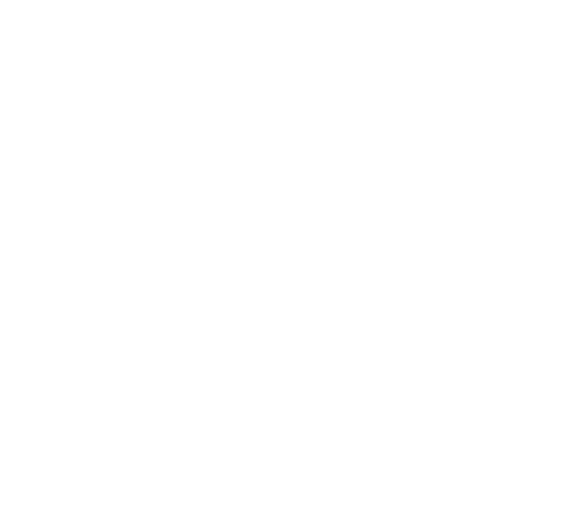

time_from 2017-01-01
time_to 2018-01-01
WCS:  <sentinelhub.data_request.WcsRequest object at 0x7fedabea0490>
avail dates list:  []
time_from 2018-01-01
time_to 2019-01-01
WCS:  <sentinelhub.data_request.WcsRequest object at 0x7fed881d4250>
avail dates list:  [datetime.datetime(2018, 9, 9, 21, 15, 4), datetime.datetime(2018, 9, 11, 21, 0, 26), datetime.datetime(2018, 9, 14, 21, 15, 59), datetime.datetime(2018, 10, 1, 21, 4, 13)]
date 2018-09-09 21:15:04
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (2134, 2376, 4)
i 2


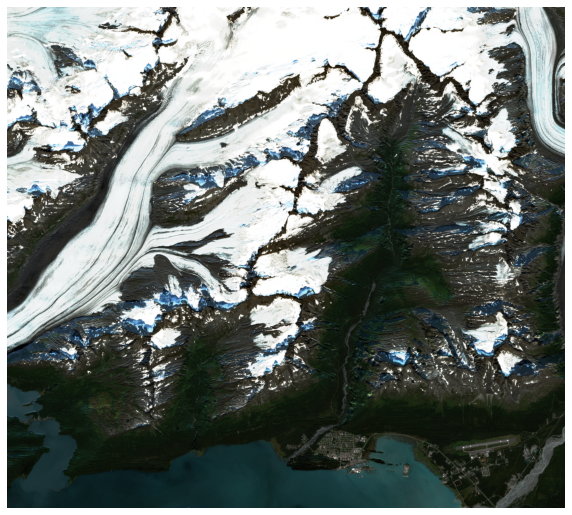

date 2018-09-11 21:00:26
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (2134, 2376, 4)
i 3


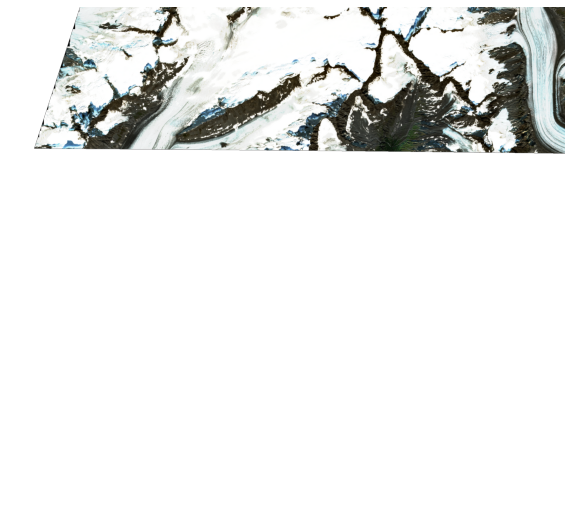

date 2018-09-14 21:15:59
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (2134, 2376, 4)
i 4


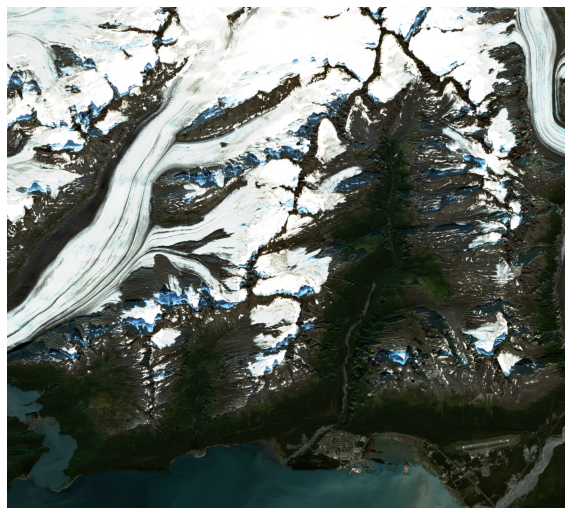

date 2018-10-01 21:04:13
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (2134, 2376, 4)
i 5


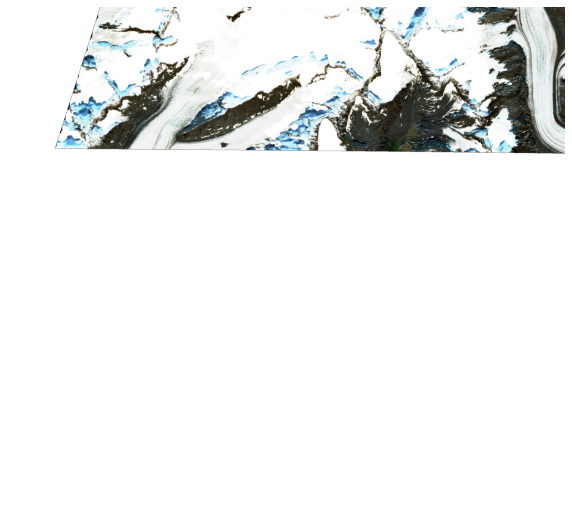

time_from 2019-01-01
time_to 2020-01-01
WCS:  <sentinelhub.data_request.WcsRequest object at 0x7fed9a254c50>
avail dates list:  [datetime.datetime(2019, 6, 29, 21, 28, 27)]
date 2019-06-29 21:28:27
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (2134, 2376, 4)
i 6


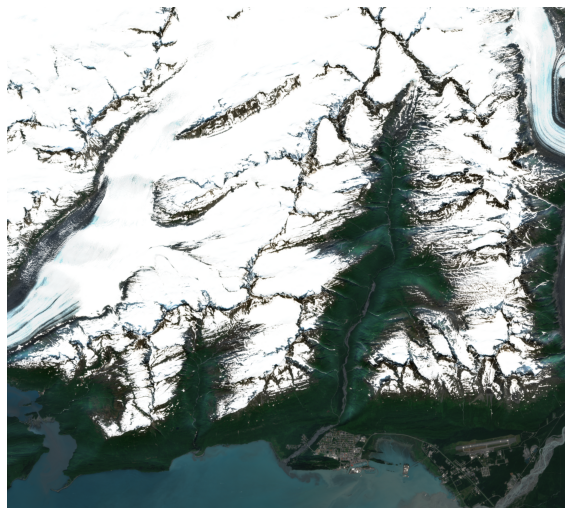

time_from 2020-01-01
time_to 2021-01-01
WCS:  <sentinelhub.data_request.WcsRequest object at 0x7fed98e7b350>
avail dates list:  [datetime.datetime(2020, 4, 18, 21, 8, 4)]
date 2020-04-18 21:08:04
Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (2134, 2376, 4)
i 7


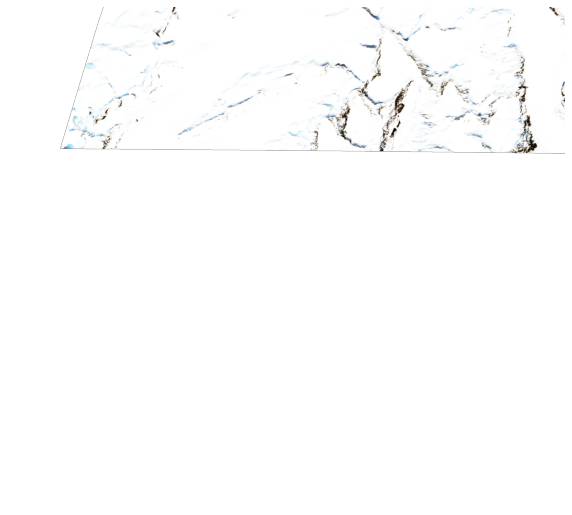

time_from 2014-01-01
time_to 2015-01-01
WCS:  <sentinelhub.data_request.WcsRequest object at 0x7fed9a22fb10>
avail dates list:  []
time_from 2015-01-01
time_to 2016-01-01
WCS:  <sentinelhub.data_request.WcsRequest object at 0x7fed9941b510>
avail dates list:  []


In [47]:
class SentinelData:
    """
    Retreiveing Sentinel data from Sentinel Hub
    initialise class with coordinates list, resolution, bounding box coordinates, years and month ranges
    make a wcs request for data between November-April
    """
    def __init__(self, coords_list, years, day_month_to, day_month_from):
        self.coords_list = coords_list
        self.resolution = '10m'
        self.area_coords = BBox(bbox=self.coords_list, crs=CRS.WGS84)
        self.year_range = years # make a set of years to iterate over 
        self.day_month_to = day_month_to
        self.day_month_from = day_month_from
        
        
        
    def retrieve_data(self):
        """ 
        Create a bounding box and assign CRS. 
        Create a wcs data request from Sentinel for Sentinel-2 data. 
        Define max clouds as 20%
        """
        for year in self.year_range:
            time_from = "{}-{}".format(year, self.day_month_from)
            print("time_from", time_from)
            time_to = "{}-{}".format(year + 1,  self.day_month_to)
            print("time_to", time_to)
            # make the request for the desired date range 
            wcs_true_color_request = WcsRequest (
                data_collection=DataCollection.SENTINEL2_L1C,
                layer='TRUE-COLOR-S2-L2A', # Layer you have configured
                bbox=self.area_coords,
                time= (time_from, time_to),
                resx=self.resolution, # Stick to 10m resolution as this the maximum possible 
                resy=self.resolution, 
                config=config,
                maxcc=0 # You can define the maximum ammount of cloud coverage you want to allow. 
            )
            print("WCS: ", wcs_true_color_request)
    
            available_dates_list = wcs_true_color_request.get_dates()
            print("avail dates list: ", available_dates_list)
            yield from available_dates_list

    def get_available_data(self):
        """
        Use get_data() function from Sentinel to retrieve available data for the dates.
        """
        available_dates_list = self.retrieve_data()
        for date in available_dates_list:
            print("date", date)
            
            wcs_true_color_request = WcsRequest(
                data_collection=DataCollection.SENTINEL2_L1C,
                layer='TRUE-COLOR-S2-L2A', # Layer you have configured
                bbox=self.area_coords, 
                time= date,
                resx='10m', # Stick to 10m resolution as this the maximum possible 
                resy=self.resolution, 
                config=config,
                maxcc=0,# You can define the maximum ammount of cloud coverage you want to allow.
                data_folder='/Users/emilybirch/Documents/UCL_Dissertation/NZ_sat_pics' 
            )
            
            basemap = wcs_true_color_request.get_data() 
            # save_data=True
            print('Returned data is of type = %s and length %d.' % (type(basemap), len(basemap)))
            print(f'Single element in the list is of type {type(basemap[-1])} and has shape {basemap[-1].shape}')
            yield from basemap
    


    # put def bands_req here         
    
    
    def plot_data(self):   
        """
        Plot the satellite data to check there is suitable cloud cover 
        and that the image is not cropped.
        """
        basemap = self.get_available_data()
        i = 0
        for sat_img in basemap:
            i += 1
            print("i", i)
           # print("SAT IMG", sat_img[0])
            fig, ax = plt.subplots(1, 1, figsize=(10,10))
            plt.imshow(sat_img)
            plt.axis('off')
            plt.savefig('ala_sat_4_{}.png'.format(i),
                        bbox_inches='tight',
                        dpi=300)
            plt.show()
          
    
    # put plot channels here 
  













 # define the years and month ranges for data. Nov-April so there is snow cover.
# Sentinel 2 data is only available from 2015 onwards


# FORESTED:

# FRANCE BBOX 1. 0%CC
#s2, w2 = 46.00263, 6.68625
#n2, e2 = 46.21018, 7.00556


# FRANCE BBOX 2. 0%CC
#s2, w2 = 44.5032, 6.26995
#n2, e2 = 44.71395, 6.57683

# FRANCE BBOX 3. 0%CC. in Vosges mountains. 
#s2, w2 = 47.89925, 6.75874
#n2, e2 = 48.0968, 7.0709




# canada 0%CC. BBOX1. CANADIAN ROCKIES
#s2, w2 = 50.82675, -116.08768
#n2, e2 = 51.02583, -115.73474
      

# CANADA BBOX2 0%CC. VANCOUVER. takes a long time to plot (90 plots) NEED 4TH PIC!!!!
#s2, w2 = 49.60259, -123.27264
#n2, e2 = 49.80043, -122.94511
    

# canada BBOX3. nr vancouver 
#s2, w2 = 49.98434, -124.25091
#n2, e2 = 50.19579, -123.90758
       
    




# NEW ZEALAND 0% CC. BBOX1. FORESTED. gets 3 3/4 pics 
#s2, w2 = -44.64093, 168.67527
#n2,e2 = -44.42578, 168.99039


# NZ BBOX 2 FORESTED. 3 pics  
#s2,w2 = -44.46215, 169.15172
#n2,e2 = -44.26874, 169.4559


# NZ BBOX 3. 3 pics 
#s2,w2 = -45.57742, 167.32814
#n2,e2 = -45.37906, 167.63988


# NZ bbox 4. 
#s2,w2 = -44.21029, 168.7185
#n2, e2 = -43.99234, 169.00415
    

##################################    
    
# NON-FORESTED:  
# Norway. scandy mountains. works but forest?
#s2, w2 = 61.19427, 6.71053
#n2, e2 = 61.39842, 7.14765
  

# BBOX 2 
# s2, w2 = 62.11413, 11.91172
#n2, e2 = 62.31454, 12.35366


# BBOX 3. nr namsos
#s2, w2 = 64.5321, 11.68324
#n2, e2 = 64.72623, 12.17067





    
# Argentina. bbox 1. 
#s2, w2 = -36.1615, -70.60757
#n2, e2 = -36.35363, -70.87261
    

# Argentina BBOX2
#s2, w2 = -36.90052, -71.07906
#n2, e2 = -36.7103, -70.80853
    
   
 # Argentina BBOX3
#s2, w2 = -48.25276, -72.33129
#n2, e2 = -48.05762, -72.0168
       
  




 # Alaska bbox1 3 pics
#s2, w2 = 60.58666, -144.4895
#n2, e2 = 60.78174, -144.04753
    
    
    
# alaska bbox 2 2 pics
#s2, w2 = 60.54723, -145.6761
#n2, e2 = 60.74312, -145.24079
    

    
# alaska bbox 3. 3 pics
#s2, w2 = 60.86118, -146.57959
#n2, e2 = 61.05052, -146.14288


# alaska bbox 4. 3 pics 
#s2, w2 = 61.10963, -146.62525
#n2, e2 = 61.30145, -146.18168
    


coords_canada = [w2, s2, e2, n2]

canada_years = {2014, 2015, 2016, 2017, 2018, 2019, 2020}

# define the years and month ranges for data. Nov-April
canada_day_month_to = "01-01"
canada_day_month_from = "01-01"



canada_data = SentinelData(coords_canada, canada_years, canada_day_month_to, canada_day_month_from)
plot_data_1 = canada_data.plot_data()


#plot_canada_data = canada_data.bands_req()
# plot the individual channels for Canada wms/ web req data
#plot_canada_wms = canada_data.web_req_data()



In [35]:
def bands_req(self):
            
        for basemap in self.get_available_data():
            wms_bands_request = WmsRequest(
                data_collection=DataCollection.SENTINEL2_L1C,
                layer='BANDS-S2-L2A', # We are using the 'BANDS-S2-L2A layer now'
                bbox=self.area_coords, 
                time=date,
                width=basemap.shape[1], # 10m resolution dims are sourced from the basemap. 
                height=basemap.shape[0],
                image_format=MimeType.TIFF, 
                config=config
            ) 
            bands = wms_bands_request.get_data()[-1]
            print("HI", type(bands))
            bands = bands.astype('float32') 
            print(bands.shape)

            plot_all_channels = self.plot_channels(bands, basemap)
            
            
            
            
def plot_channels(self, bands, basemap):
    """
    Plot out each channel to see how they look
    """
    b01 = bands[:,:,0] # Coastal Aerosol
    b02 = bands[:,:,1] # Blue
    b03 = bands[:,:,2] # Green
    b04 = bands[:,:,3] # Red
    b05 = bands[:,:,4] # Vegetation Red Edge 
    b06 = bands[:,:,5] # Vegetation Red Edge
    b07 = bands[:,:,6] # Vegetation Red Edge
    b08 = bands[:,:,7] # NIR
    b08a = bands[:,:,8] # Vegetation Red Edge
    b09 = bands[:,:,9] # Water Vapour
    b11 = bands[:,:,10] # SWIR
    b12 = bands[:,:,11] # SWIR

    for channel in bands:
        fig, ax = plt.subplots(2, 6, figsize=(15,6))
        ax[0, 0].imshow(b01, cmap='cubehelix')
        ax[0, 0].set_title('Coastal Aerosol')
        ax[0, 0].axis('off')
        ax[0, 1].imshow(b02, cmap='cubehelix')
        ax[0, 1].set_title('Blue')
        ax[0, 1].axis('off')
        ax[0, 2].imshow(b03, cmap='cubehelix')
        ax[0, 2].set_title('Green')
        ax[0, 2].axis('off')
        ax[0, 3].imshow(b04, cmap='cubehelix')
        ax[0, 3].set_title('Red')
        ax[0, 3].axis('off')
        ax[0, 4].imshow(b05, cmap='cubehelix')
        ax[0, 4].set_title('Vegetation Red Edge ')
        ax[0, 4].axis('off')
        ax[0, 5].imshow(b07, cmap='cubehelix')
        ax[0, 5].set_title('Vegetation Red Edge ')
        ax[0, 5].axis('off')
        ax[1, 0].imshow(b08, cmap='cubehelix')
        ax[1, 0].set_title('Vegetation Red Edge ')
        ax[1, 0].axis('off')
        ax[1, 1].imshow(b08a, cmap='cubehelix')
        ax[1, 1].set_title('NIR')
        ax[1, 1].axis('off')
        ax[1, 2].imshow(b09, cmap='cubehelix')
        ax[1, 2].set_title('Vegetation Red Edge')
        ax[1, 2].axis('off')
        ax[1, 3].imshow(b11, cmap='cubehelix')
        ax[1, 3].set_title('SWIR')
        ax[1, 3].axis('off')
        ax[1, 4].imshow(b12, cmap='cubehelix')
        ax[1, 4].set_title('SWIR')
        ax[1, 4].axis('off')
        ax[1, 5].imshow(basemap, cmap='cubehelix')
        ax[1, 5].set_title('True Colour composite')
        ax[1, 5].axis('off')
        plt.show()


If you just wanted to download a true colour composite, you could use WcsRequest()

If you want to access the full Sentinel-2 product (with all channels) you can use wms request. 

We can  then use band 2 and band 11 (SWIR and Blue) to create a normalised difference snow index (NDSI) and the normalised difference water index

In [ ]:
# use more than one channel as input into my model. use geomorphology too.



# A guide for Spectral indicies:
# https://www.geo.university/pages/blog?p=spectral-indices-with-multispectral-satellite-data

# Normalised difference snow index 
NDSI = (b03 - b11)/(b03 + b11)

# Normalised difference water index 
NDWI = (b03 - b08)/(b03 + b08)


# Normalised difference vegetation index ?


I chose a region where both water and snow are present. 
This shows that when trying to isolate snow, we also isolate water. 

But when isolating water, we, the snow is mostly left out.
This means that we can use both indicies to generate some training data

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,10))
# ax.imshow(basemap)
ax[0].imshow(basemap)
ax[0].set_title('True Colour Composite')

ax[1].imshow(NDSI, cmap='Blues')
ax[1].set_title('NDSI')

ax[2].imshow(NDWI, cmap='Blues')
ax[2].set_title('NDWI')

plt.savefig('NDSI.png', dpi=600)
plt.show()

In [ ]:
def to_mask(input_image, threshold):
    input_image[input_image <= threshold] = np.nan
    input_image[input_image > threshold] = 1
    return input_image
    
NDWI_mask = to_mask(NDWI, 0.2)
NDSI_mask = to_mask(NDSI, 0.)
fig, ax = plt.subplots(1, 4, figsize=(15,10))
ax[0].set_title('NDWI Water mask')
ax[0].imshow(basemap)
ax[0].imshow(NDWI_mask, cmap='cubehelix')
ax[1].set_title('NDSI Snow mask')
ax[1].imshow(basemap)
ax[1].imshow(NDSI_mask, cmap='cubehelix')

NDWI_binary_mask = np.nan_to_num(NDWI_mask)
NDSI_binary_mask = np.nan_to_num(NDSI_mask)
both = NDWI_binary_mask + NDSI_binary_mask

ax[2].set_title('NDSI mask + NDWI mask')
ax[2].imshow(both, cmap='cubehelix')

ax[3].set_title('Snow mask - Water removed')
snow_only = both.copy()
snow_only[snow_only == 2] = 0
ax[3].imshow(snow_only, cmap='cubehelix')

CNN's usually don't accept big inputs, so the image needs to be cropped into smaller samples.

The bigger and more complex the CNN, the more processing power will be required, therefore the smaller the input samples will need to be. 

Rather than crushing the original sample, a good idea is to splice it. 
This way we get a lot more data, and the 10m resolution is maintained. 

In [ ]:
import math

# Split the Images
def split_image(dim_pix, im):
    # Find the number of sub-Images that fit in rows
    rows = []
    tiles = []
    for i in range((math.floor(im.shape[0] / dim_pix))):
        rows.append(i)
    # Find the number of sub-Images that fit in rows
    columns = []
    for i in range((math.floor(im.shape[1] / dim_pix))):
        columns.append(i)

    # Numerically identify the sub-Images
    a = 0
    for i in rows:
        for j in columns:
            # Check for 244 x 244 (Mask) or 244 x 244 x 3 (TC Images)
            if (im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                  0 + dim_pix * i: dim_pix + (dim_pix * i)].shape[0]) == dim_pix:
                if (im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                  0 + dim_pix * i: dim_pix + (dim_pix * i)].shape[1]) == dim_pix:

                    tile = im[0 + (dim_pix * j): dim_pix + (dim_pix * j),
                            0 + dim_pix * i: dim_pix + (dim_pix * i)]

                    # Stop white tiles for positive results
                    count = np.count_nonzero(tile == 1) == (dim_pix * dim_pix)
                    if count:
                        all_black = np.tile(1, (dim_pix, dim_pix))
                        tiles.append(tile)
                    else:
                        tiles.append(tile)
                    a += 1
                else:
                    print("Out of shape")
    return tiles

input_tensor_dimensions = 50
                    
basemap_tiles = split_image(dim_pix=input_tensor_dimensions, im=basemap)
label_tiles = split_image(dim_pix=input_tensor_dimensions, im=snow_only)

fig, ax = plt.subplots(len(label_tiles), 2, figsize=(2 ,len(label_tiles)))
for index in range(len(label_tiles)):
    ax[index, 0].axis('off')
    ax[index, 1].axis('off')
    ax[index, 0].imshow(basemap_tiles[index])
    ax[index, 1].imshow(label_tiles[index], cmap='Blues')